In [8]:
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score
from sklearn import metrics
import torch
from torch import nn

from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper parameters
num_epochs = 15
batch_size = 128
learning_rate = 0.001

h5_file = "../data/test/tf_peaks_TEST_sparse_Remap.h5"
if not os.path.exists(h5_file):
    os.system(f"zless {h5_file}.gz > {h5_file}")

dataloaders, target_labels, train_out = tools.load_datas(h5_file,
                                                         batch_size,
                                                         0,
                                                         True)

target_labels = [i.decode("utf-8") for i in target_labels]

num_cnns = 100
input_length = 200
num_classes = len(target_labels)
filter_size = 19


model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Dataset Loaded


Epoch [1], Current Train Loss: 0.59987, Current Val Loss: 0.56369
Epoch [2], Current Train Loss: 0.54444, Current Val Loss: 0.53805
Epoch [3], Current Train Loss: 0.52748, Current Val Loss: 0.53336
Epoch [4], Current Train Loss: 0.51762, Current Val Loss: 0.53094
Epoch [5], Current Train Loss: 0.50993, Current Val Loss: 0.53307
Epoch [6], Current Train Loss: 0.50374, Current Val Loss: 0.53503
Epoch [7], Current Train Loss: 0.49772, Current Val Loss: 0.53951
Epoch [8], Current Train Loss: 0.49197, Current Val Loss: 0.54223
Epoch [9], Current Train Loss: 0.48682, Current Val Loss: 0.54598
Epoch [10], Current Train Loss: 0.48281, Current Val Loss: 0.54929
Epoch [11], Current Train Loss: 0.47698, Current Val Loss: 0.55144
Epoch [12], Current Train Loss: 0.47213, Current Val Loss: 0.55527
Epoch [13], Current Train Loss: 0.46811, Current Val Loss: 0.55749
Epoch [14], Current Train Loss: 0.46451, Current Val Loss: 0.56207
Epoch [15], Current Train Loss: 0.45895, Current Val Loss: 0.56459


<Figure size 640x480 with 0 Axes>

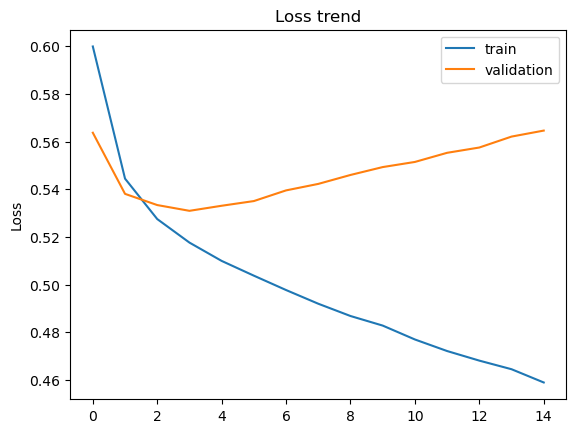

In [11]:
weights_folder = "../data/test/weights"
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)

model, train_error, test_error = train.train_explainn(dataloaders["train"],
                                                      dataloaders["valid"],
                                                      model,
                                                      device,
                                                      criterion,
                                                      optimizer,
                                                      num_epochs,
                                                      weights_folder,
                                                      name_ind="",
                                                      verbose=True,
                                                      trim_weights=False,
                                                      checkpoint=0,
                                                      patience=0)

tools.showPlot(train_error, test_error, "Loss trend", "Loss")

In [12]:
model.load_state_dict(torch.load(f"{weights_folder}/{os.listdir(weights_folder)[0]}"))

labels_E, outputs_E = test.run_test(model, dataloaders["test"], device)
pr_rec = average_precision_score(labels_E, outputs_E)

no_skill_probs = [0 for _ in range(len(labels_E[:, 0]))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(labels_E[:, 0], no_skill_probs)

roc_aucs = {}
raw_aucs = {}
roc_prcs = {}
raw_prcs = {}
for i in range(len(target_labels)):
    nn_fpr, nn_tpr, threshold = metrics.roc_curve(labels_E[:, i], outputs_E[:, i])
    roc_auc_nn = metrics.auc(nn_fpr, nn_tpr)

    precision_nn, recall_nn, thresholds = metrics.precision_recall_curve(labels_E[:, i], outputs_E[:, i])
    pr_auc_nn = metrics.auc(recall_nn, precision_nn)

    raw_aucs[target_labels[i]] = nn_fpr, nn_tpr
    roc_aucs[target_labels[i]] = roc_auc_nn

    raw_prcs[target_labels[i]] = recall_nn, precision_nn
    roc_prcs[target_labels[i]] = pr_auc_nn

print(roc_prcs)
print(roc_aucs)

{'MAX': 0.8231038676047618, 'FOXA1': 0.8951274744933946, 'JUND': 0.7564607844103842}
{'MAX': 0.8026641706924316, 'FOXA1': 0.8092293981232892, 'JUND': 0.7530387768526094}


In [13]:
dataset, data_inp, data_out = tools.load_single_data(h5_file,
                                                     batch_size,
                                                     0,
                                                     False)

predictions, labels = interpretation.get_explainn_predictions(dataset,
                                                              model,
                                                              device,
                                                              isSigmoid=True)

# only well predicted sequences
pred_full_round = np.round(predictions)
arr_comp = np.equal(pred_full_round, labels)
idx = np.argwhere(np.sum(arr_comp, axis=1) == len(target_labels)).squeeze()

data_inp = data_inp[idx, :, :]
data_out = data_out[idx, :]

dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0)

activations = interpretation.get_explainn_unit_activations(data_loader, model, device)
pwms = interpretation.get_pwms_explainn(activations, data_inp, filter_size)
meme_file = "../data/test/explainn_filters.meme"
interpretation.pwm_to_meme(pwms, meme_file)

100%|████████████████████| 100/100 [00:15<00:00,  6.49it/s]

Saved PWM File as : ../data/test/explainn_filters.meme


In [15]:
tomtom_file = "./data/test/MAX_JUND_FOXA1_tomtom.tsv"
jaspar_meme = "./data/JASPAR/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt"
os.system(f"tomtom --text {meme_file} {jaspar_meme} > {tomtom_file}")

The output directory '../data/test/MAX_JUND_FOXA1_tomtom' already exists.
Its contents will be overwritten.
Processing query 1 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997615
#   Estimated pi_0=0.997615
Processing query 2 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994019
#   Estimated pi_0=0.995595
Processing query 3 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00233
#   Estimated pi_0=1
Processing query 4 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994921
#   Estimated pi_0=0.994921
Processing query 5 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.003
#   Estimat

# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00368
#   Estimated pi_0=1
Processing query 47 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.990206
#   Estimated pi_0=0.990206
Processing query 48 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998289
#   Estimated pi_0=0.998289
Processing query 49 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.96805
#   Estimated pi_0=0.969959
Processing query 50 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.944755
#   Estimated pi_0=0.945283
Processing query 51 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00062
#   Estimated pi_0=1
Processing query 93 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993574
#   Estimated pi_0=0.993574
Processing query 94 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00233
#   Estimated pi_0=1
Processing query 95 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.003
#   Estimated pi_0=1
Processing query 96 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 97 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_

256

In [16]:
tomtom_results = pd.read_table(f"{tomtom_file}", comment="#")

filters_with_min_q = tomtom_results.groupby("Query_ID").min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

jaspar_motifs = {}
with open(jaspar_meme) as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            jaspar_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([jaspar_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)

In [34]:
weights = model.final.weight.detach().cpu().numpy()

filters = ["filter"+str(i) for i in range(num_cnns)]
for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]

weight_df = pd.DataFrame(weights, index=target_labels, columns=filters)

<Figure size 1500x1000 with 0 Axes>

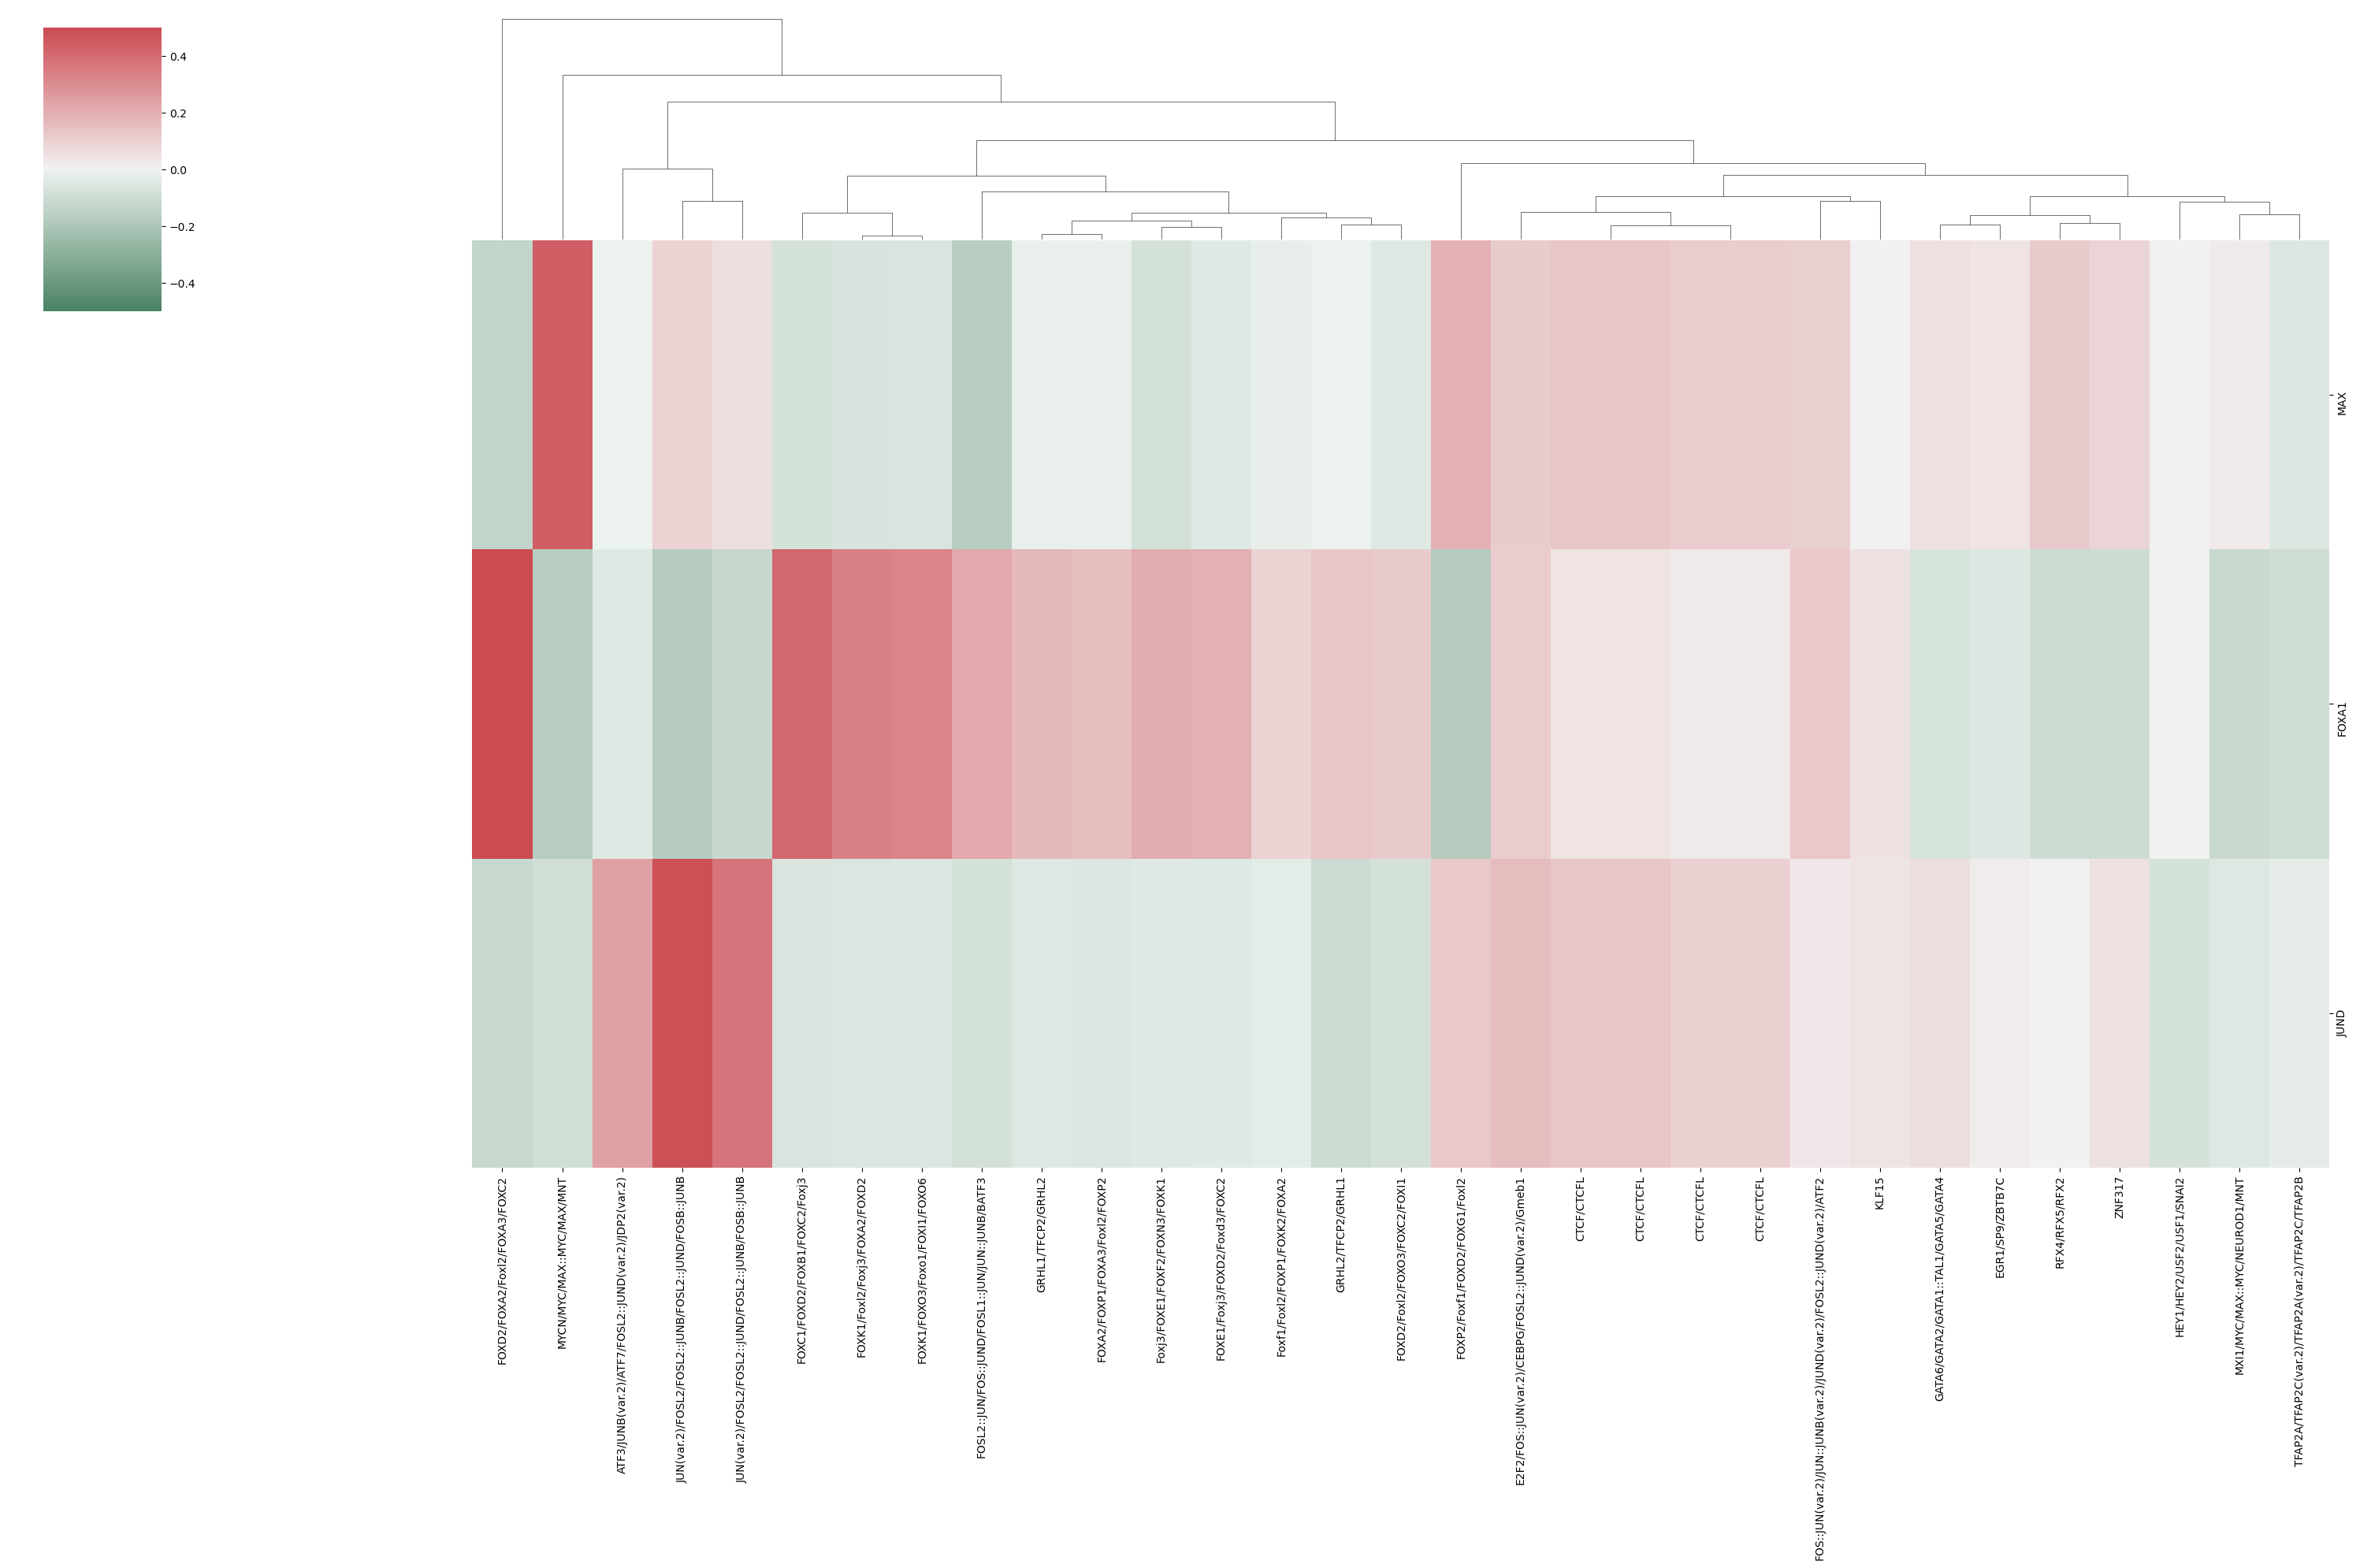

In [35]:
plt.figure(figsize=(15, 10))
# focus on annotated filters only
sns.clustermap(weight_df[[i for i in weight_df.columns if not i.startswith("filter")]],
               cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True),
               row_cluster=False,
               figsize=(30, 20),
               vmax=0.5,
               vmin=-0.5)
plt.show()

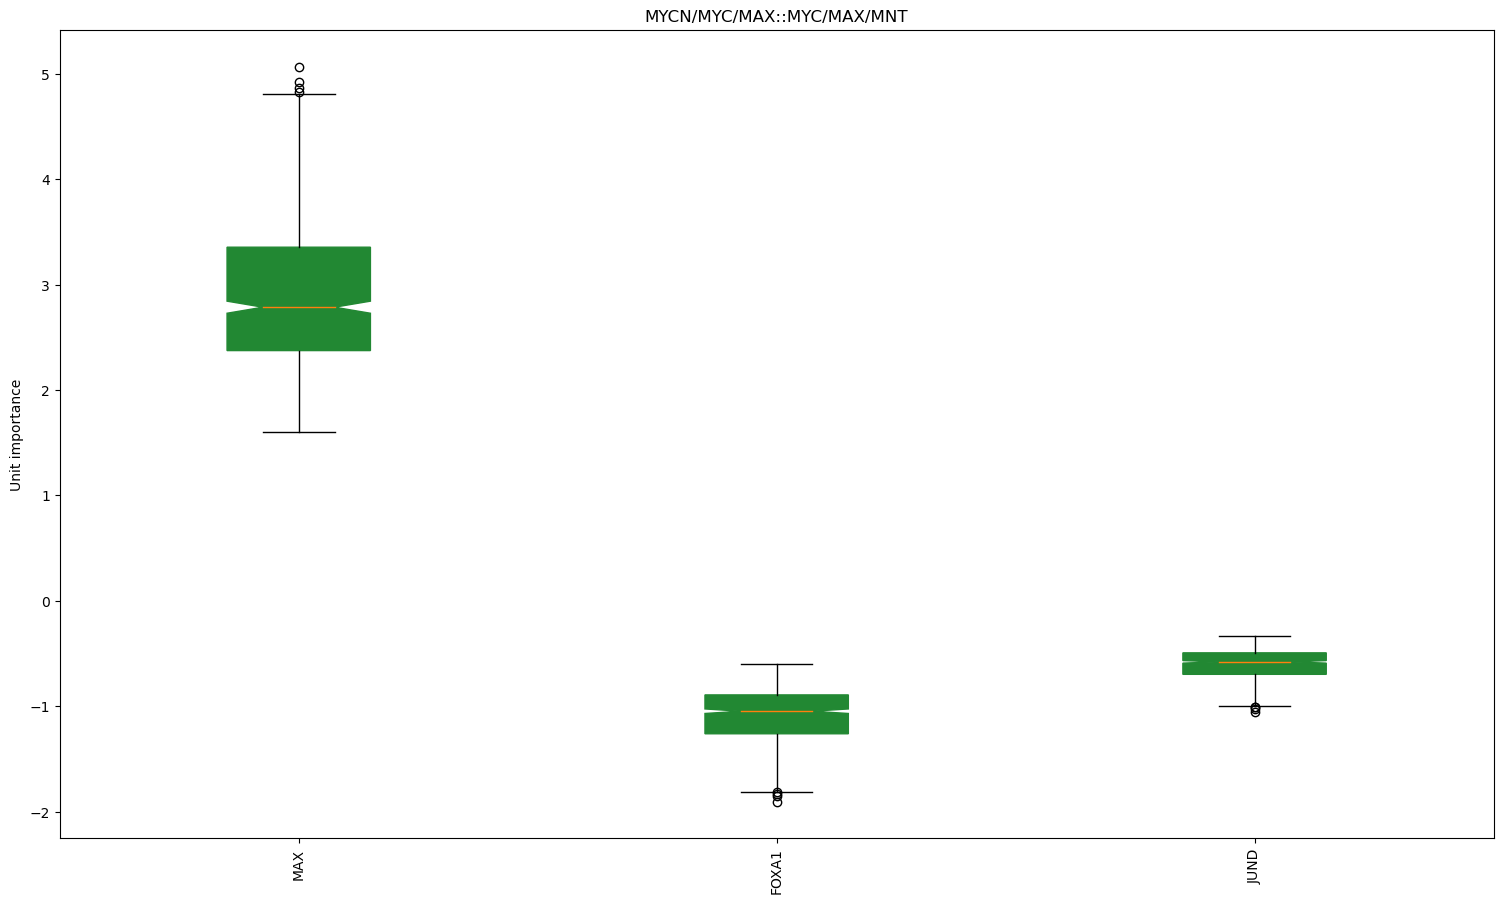

In [36]:
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, model, device)

best_filters = weight_df.idxmax(axis="columns")
best_myc_max_filter = weight_df.columns.get_loc(best_filters["MAX"])

unit_importance = interpretation.get_specific_unit_importance(activations,
                                                              model,
                                                              unit_outputs,
                                                              best_myc_max_filter,
                                                              target_labels)

filter_key = f"filter{best_myc_max_filter}"
title = annotation[filter_key] if filter_key in annotation.index else filter_key
fig, ax = plt.subplots()
datas = [filt_dat for filt_dat in unit_importance]
ax.boxplot(datas, notch=True, patch_artist=True, boxprops=dict(facecolor="#228833", color="#228833"))
fig.set_size_inches(18.5, 10.5)
plt.title(title)
plt.ylabel("Unit importance")
plt.xticks(range(1, len(target_labels)+1), target_labels)
plt.xticks(rotation=90)
plt.show()